In [15]:
from cirq_sic import *
from cirq.contrib.svg import SVGCircuit

import numpy as np
np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt

In [16]:
processor_id = "willow_pink"
globals().update(get_device_data(processor_id))

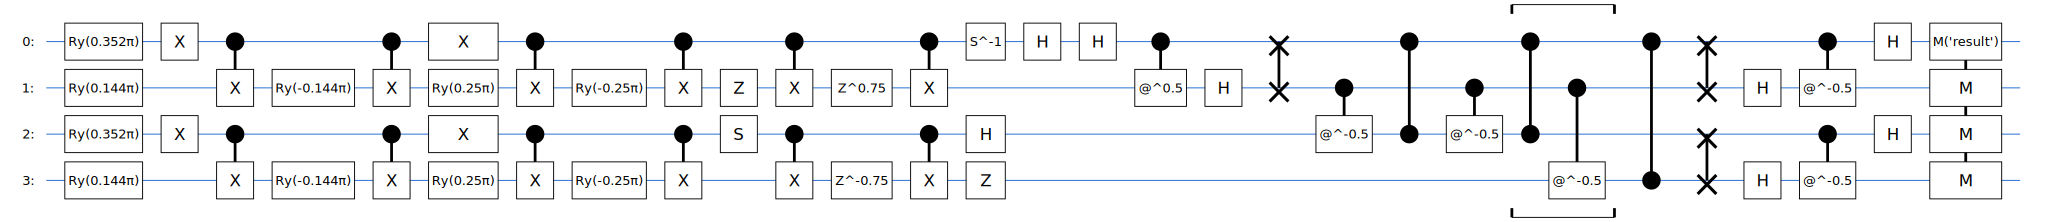

In [17]:
n = 2
q = cirq.LineQubit.range(2*n)
A, B = q[:n], q[n:2*n]

# 1) Prepare fiducial in A (system) and conjuate fiducial in B (ancilla).
# 2) Apply controlled shift (A: target, B: control)
# 3) Inverse fourier transform B. This implements the operator D.
# 4) Measuring in computational basis realize the WH-POVM.
circuit = cirq.Circuit((d4_sic_fiducial(A),\
                        d4_sic_fiducial(B, conjugate=True),\
                        simple_AK(A, B, measure=True)))
SVGCircuit(circuit)

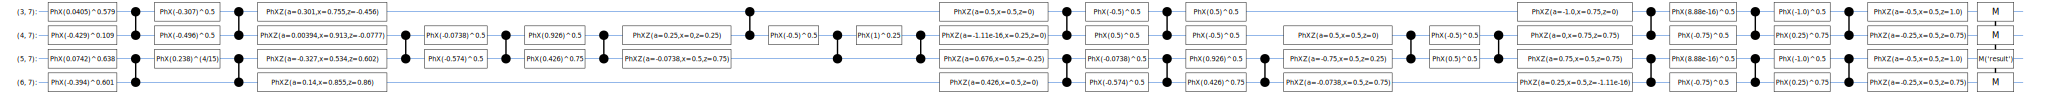

In [18]:
optimized_circuit = process_circuit(circuit, connectivity_graph, gateset)
device.validate_circuit(optimized_circuit)
SVGCircuit(optimized_circuit)

In [19]:
# Exact simulation
N = 50000
s = cirq.Simulator()
samples = s.run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")
exact_freqs =  np.array([v for k, v in sorted(counts.items())])/N
exact_freqs

array([0.248, 0.05 , 0.048, 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.051,
       0.051, 0.05 , 0.051, 0.05 , 0.051, 0.05 , 0.049])

In [20]:
# Direct calculation
d = 4
phi = d4_sic_fiducial_ket()
E = wh_povm(phi)
p = np.array([phi.conj() @ e @ phi for e in E]).real; p

array([0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05])

In [21]:
# Noisy simulation
N = 10000
samples = sampler.run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")
noisy_freqs = np.array([v for k, v in sorted(counts.items())])/N

# To compare this side by side with the AK result, we reorder the probabilities to reflect that
# we've changed convention from D^\dag \Pi D to D \Pi D^\dag
noisy_freqs = change_conjugate_convention(noisy_freqs)
noisy_freqs

array([0.211, 0.052, 0.058, 0.058, 0.058, 0.026, 0.022, 0.056, 0.092,
       0.043, 0.064, 0.037, 0.049, 0.069, 0.056, 0.05 ])

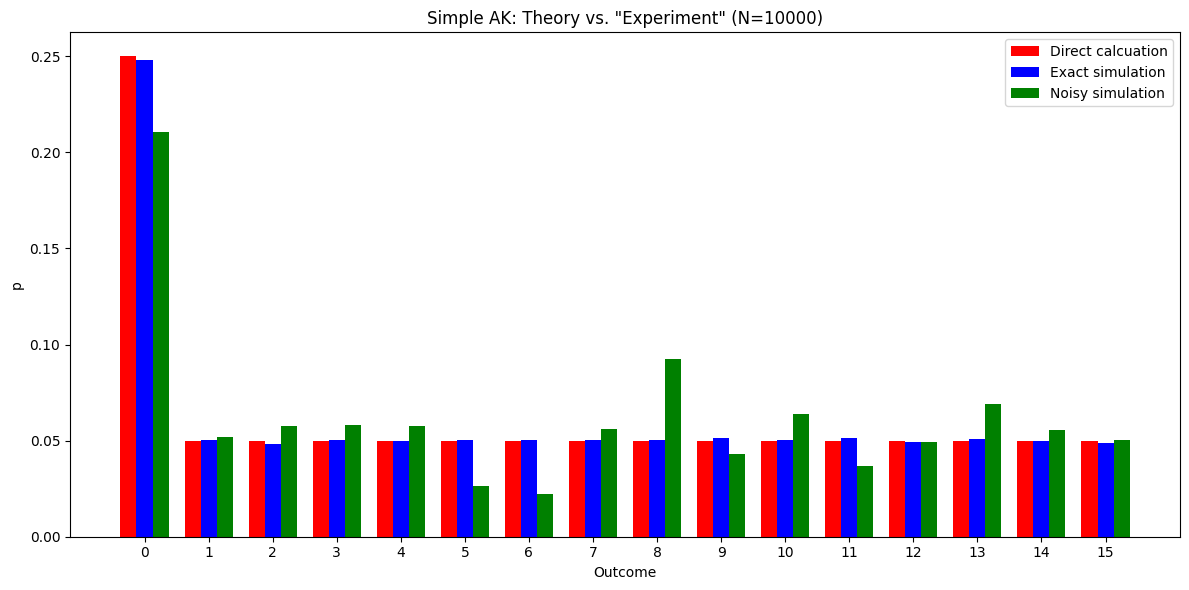

In [22]:
x_pos = np.arange(2**4) 
bar_width = 0.25
plt.figure(figsize=(12, 6))
plt.bar(x_pos - bar_width, p, width=bar_width, label='Direct calcuation', color='red')
plt.bar(x_pos, exact_freqs, width=bar_width, label='Exact simulation', color='blue')
plt.bar(x_pos + bar_width, noisy_freqs, width=bar_width, label='Noisy simulation', color='green')
plt.ylabel('p')
plt.xlabel('Outcome')
plt.title('Simple AK: Theory vs. "Experiment" (N=%d)' % N)
plt.xticks(x_pos)
plt.legend()
plt.tight_layout()

## Gate counts

In [23]:
simple_circuit = cirq.Circuit((simple_AK(A, B, measure=False)))
get_gate_counts(simple_circuit)

--- Gate Counts (by type) ---
HPowGate: 6
CZPowGate: 9
SwapPowGate: 3


In [24]:
len(simple_circuit.moments)

13

In [25]:
get_gate_counts(optimized_circuit)

--- Gate Counts (by type) ---
PhasedXPowGate: 31
CZPowGate: 23
PhasedXZGate: 21
MeasurementGate: 1


In [26]:
len(optimized_circuit.moments)

34